### IMDB 영화 리뷰 데이터

In [ ]:
# 리뷰가 긍정이면 : 1, 부정이면 : 0
# 감정 분석 - 불용어 제거,,,

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

# 모델 생성
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, GlobalMaxPool1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data() # 자동으로 50:50으로 나눔.

In [3]:
print(f'훈련 데이터: {len(X_train)}')
print(f'검증(테스트) 데이터: {len(X_test)}')
num_classes = len(set(Y_train)) # 중복 X
print(f'카테고리: {num_classes}')

훈련 데이터: 25000
검증(테스트) 데이터: 25000
카테고리: 2


In [4]:
# 토큰화, padding 되어 있는 데이터
X_train 

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [6]:
print('첫번째 훈련용 리뷰 데이터:', X_train[0])
print('첫번째 훈련용 리뷰 데이터 레이블:', Y_train[0])

첫번째 훈련용 리뷰 데이터: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫번째 훈련용 리뷰 데이터 레이블: 

리뷰의 최대 길이: 2494
리뷰의 평균 길이: 238.71364


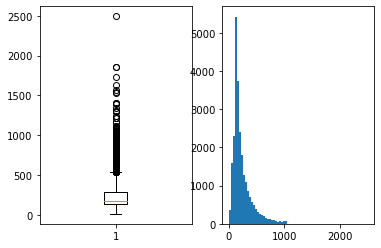

In [8]:
# 리뷰 길이 그래프
review_length = [len(review) for review in X_train]

print('리뷰의 최대 길이:', np.max(review_length))
print('리뷰의 평균 길이:', np.mean(review_length))

# subplot(행, 열, index(첫번째,,)) - 여러 개의 그래프를 하나의 그림에 나타냄.
plt.subplot(1, 2, 1)
plt.boxplot(review_length)
plt.subplot(1, 2, 2)
plt.hist(review_length, bins = 70) # 더 자세히
plt.show()

In [9]:
# 그래프를 보면, 1000 이하의 리뷰 데이터가 많고, 100 ~ 500 사이의 데이터가 많을 것을 알 수 있음.
# 레이블의 분포
np.unique(Y_train, return_counts = True) # 절반씩 분포

(array([0, 1], dtype=int64), array([12500, 12500], dtype=int64))

In [11]:
unique_elements, counts_elements = np.unique(Y_train, return_counts = True)
print('각 레이블의 빈도수')
print(np.asarray((unique_elements, counts_elements)))

각 레이블의 빈도수
[[    0     1]
 [12500 12500]]


In [13]:
# X_train에 들어있는 숫자들이 각각 어떤 단어들을 나타내는지 알아보겠습니다,,
imdb.get_word_index() # imdb.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑되는 정수(규칙)

1654784/1641221 [==============================] - 0s 0us/step


{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [15]:
word_index = imdb.get_word_index()
index_to_word = {} # 딕셔너리 형태
for key, value in word_index.items():
    index_to_word[value + 3] = key 

In [16]:
index_to_word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [17]:
print('빈도수 상위 1등 단어:', index_to_word[4]) # IMDB 리뷰 데이터셋에서는 0, 1, 2, 3은 특별 토큰 취급. 정수 4부터 -> 빈도수가 가장 높음.

빈도수 상위 1등 단어: the


In [18]:
# 인덱스 번호가 작을 수록 빈도수 높음.
print('빈도수 상위 3838등 단어:', index_to_word[3841])

빈도수 상위 3838등 단어: freak


In [19]:
print('빈도수 상위 3938등 단어:', index_to_word[3941])

빈도수 상위 3938등 단어: suited


In [20]:
# 첫번째 훈련용 리뷰의 X_train[0]의 각 단어가 정수로 바뀌기 전에 어떤 단어들이었는지 알아보겠습니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]])) # '구분자'.join(리스트)

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

In [21]:
vocab_size = 10000 # 단어 집합의 크기
max_len = 500 # 리뷰 최대의 길이 -> padding

(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words = vocab_size) # 사용 빈도가 높은 10000개 단어

In [22]:
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}, X_test: {X_test.shape}, Y_test: {Y_test.shape}')

X_train: (25000,), Y_train: (25000,), X_test: (25000,), Y_test: (25000,)


In [23]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [24]:
print(X_train[:3])

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [28]:
# 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 추출 -> 없네요,,
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 4]
len(drop_train)

0

In [30]:
# padding
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [31]:
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}, X_test: {X_test.shape}, Y_test: {Y_test.shape}')

X_train: (25000, 500), Y_train: (25000,), X_test: (25000, 500), Y_test: (25000,)


### Generate a model

In [33]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, return_sequences = True)) # many to many
model.add(GlobalMaxPool1D())
model.add(Dense(1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model1.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         117248    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [34]:
r = model.fit(X_train, Y_train, callbacks = [es, mc], validation_split = 0.2, epochs = 15, batch_size = 64)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4602 - acc: 0.7693
Epoch 1: val_acc improved from -inf to 0.85460, saving model to best_model1.h5
313/313 [==============================] - 245s 776ms/step - loss: 0.4602 - acc: 0.7693 - val_loss: 0.3470 - val_acc: 0.8546
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.2355 - acc: 0.9079
Epoch 2: val_acc improved from 0.85460 to 0.86920, saving model to best_model1.h5
313/313 [==============================] - 769s 2s/step - loss: 0.2355 - acc: 0.9079 - val_loss: 0.3056 - val_acc: 0.8692
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.1574 - acc: 0.9437
Epoch 3: val_acc improved from 0.86920 to 0.87960, saving model to best_model1.h5
313/313 [==============================] - 768s 2s/step - loss: 0.1574 - acc: 0.9437 - val_loss: 0.3232 - val_acc: 0.8796
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.1047 - acc: 0.9642
Epoch 4: val_acc improve

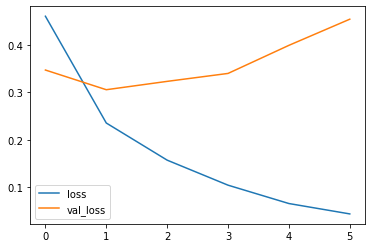

In [35]:
# 시각화 - loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

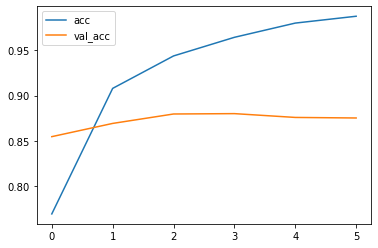

In [37]:
# 시각화 - accuracy
plt.plot(r.history['acc'], label = 'acc')
plt.plot(r.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

In [38]:
# 모델 평가
loaded_model = load_model('best_model1.h5')
loaded_model.evaluate(X_test, Y_test) # 정확도 86.73%

782/782 [==============================] - 56s 71ms/step - loss: 0.3713 - acc: 0.8673


[0.3713310956954956, 0.8673200011253357]

In [39]:
# 문장 예측 - 평점 5점 리뷰
review1 = 'There were too many unnecessary scenes for visitors, and the atmosphere in the beginning disappeared as the last minute went by. But Choi Minsik\'s acting was the best.'
review1

"There were too many unnecessary scenes for visitors, and the atmosphere in the beginning disappeared as the last minute went by. But Choi Minsik's acting was the best."

In [43]:
# 함수로 만들기
def review_predict(new_review):
    
    # 알파벳과 숫자, 공백을 제외하고 모두 제거 및 알파벳 소문자화
    new_review = re.sub('[^0-9a-zA-Z ]', '', new_review).lower()
    encoded = []
    
    # 띄어쓰기 단위 토큰화 후 정수 인코딩
    for text in new_review.split():
        try: # try: - except [발생 오류[as 오류 메시지 변수]]: (try 블록에서 오류가 나면 except 블록이 실행됨.)
            # 단어 집합의 크기를 10,000으로 제한.
            if word_index[text] <= 10000: # word_index에는 사용된 단어와 빈도수대로 나열된 숫자로 이루어짐.
                encoded.append(word_index[text] + 3)
            else:
                # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
                encoded.append(2)
        # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
        except KeyError:
            encoded.append(2)
            
    pad_sequence = pad_sequences([encoded], maxlen = max_len)
    
    # predict
    score = float(loaded_model.predict(pad_sequence))
    
    # 결과 값 판단
    if score > 0.5:
        print('{:.2f}% 확률로 긍정 리뷰'.format(score * 100))
    else:
        print('{:.2f}% 확률로 부정 리뷰'.format((1 - score) * 100))

In [44]:
review_predict(review1)

76.20% 확률로 긍정 리뷰


In [45]:
# 평점 4점 리뷰
review2 = 'It\'s a pity that the story ended up not being able to handle it.'
review2

"It's a pity that the story ended up not being able to handle it."

In [46]:
review_predict(review2)

66.34% 확률로 긍정 리뷰
